# Inverse Kinematics on Stretch

This tutorial looks at doing inverse kinematics on Stretch. It'll use the [IKPy](https://github.com/Phylliade/ikpy) and [Stretch Body](https://github.com/hello-robot/stretch_body) to solve for and execute end effector goals on the robot.

**Prerequisites**:
 - A Stretch RE1 or Stretch 2 robot
 - Either the Standard gripper or Dex Wrist attached to the robot
 - Beginner level familiarity with Python and Linear Algebra

**How to run**
 1. Power on and connect to Stretch (keyboard/mouse/HDMI or via SSH)
 2. Navigate to the directory this notebook lives in and run `jupyter notebook --no-browser`
 3. If SSH-ed, open a tunnel for Jupyter using `ssh -L 8888:localhost:8888 <ip addr>`
 4. Click on Jupyter's link (e.g. looks like `http://localhost:8888/?token=<some token>`)
 5. Shift + Enter to execute the cells below

In [1]:
!pip3 install -q ikpy
!pip3 install -q graphviz
!pip3 install -q ipympl

In [2]:
import stretch_body.robot

# Setup the Python API
robot = stretch_body.robot.Robot()
if not robot.startup():
    print("Failed to open connection to the robot")

# Ensure robot is homed
if not robot.is_calibrated():
    robot.home()

--------- Homing Head ----
--------- Homing Lift ----
Homing Lift...


[INFO] [robot_monitor]: Guarded contact lift
[INFO] [robot_monitor]: Wrist single tap: 6
[INFO] [robot_monitor]: Base bump event


Hardstop detected at motor position (rad) 88.9416275024414
Marking Lift position to 1.096228 (m)
Marking Lift position to 0.000000 (m)


[INFO] [robot_monitor]: Base bump event


Lift homing successful
--------- Homing Arm ----
Homing Arm...


[INFO] [robot_monitor]: Guarded contact arm
[INFO] [robot_monitor]: Wrist single tap: 7


Hardstop detected at motor position (rad) 1.4257595539093018
Marking Arm position to 0.000000 (m)


[INFO] [robot_monitor]: Wrist single tap: 8


Arm homing successful
--------- Homing stretch_gripper ----
Moving to first hardstop...
First hardstop contact at position (ticks): 31
-----
Homing offset was 4387
Marking current position to zero ticks
Homing offset is now  4355 (ticks)
-----
Current position (ticks): 25
Moving to calibrated zero: (rad)
--------- Homing wrist_yaw ----
Moving to first hardstop...
First hardstop contact at position (ticks): 4089
-----
Homing offset was 1935
Marking current position to zero ticks
Homing offset is now  -2159 (ticks)
-----
Current position (ticks): 29
Moving to calibrated zero: (rad)


[INFO] [robot_monitor]: Wrist single tap: 10


## Theory

Robots are often built as a chain of "links", connected at "joints". Just like the human arm, which we could think of as torso, upper arm, forearm, and hand "links", connected by shoulder, elbow, and wrist "joints".

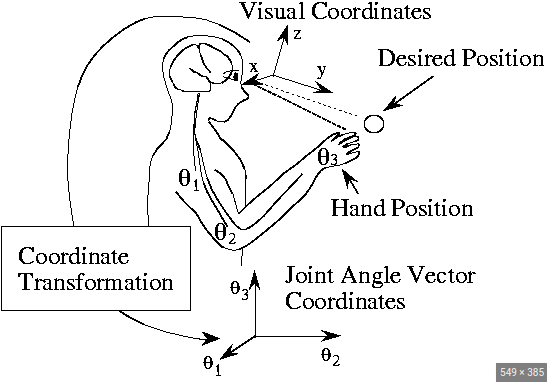
[Source](https://realitybytes.blog/2017/06/16/forward-and-inverse-kinematics-an-introduction/)

In robotics, **Forward Kinematics (FK)** is the problem of determining where the end of the chain will be given joint positions. Often, there's some tool at the end of the chain, called the "end-effector", like a gripper or hand. **Inverse Kinematics (IK)** is the opposite problem: find the joint positions for the chain that allows it to reach to a target position in space. With Stretch, the chain of links starts in the robot's base and goes until the Stretch Gripper at the end of the arm. For example, here's what Stretch's chain looks like with the Dex Wrist:

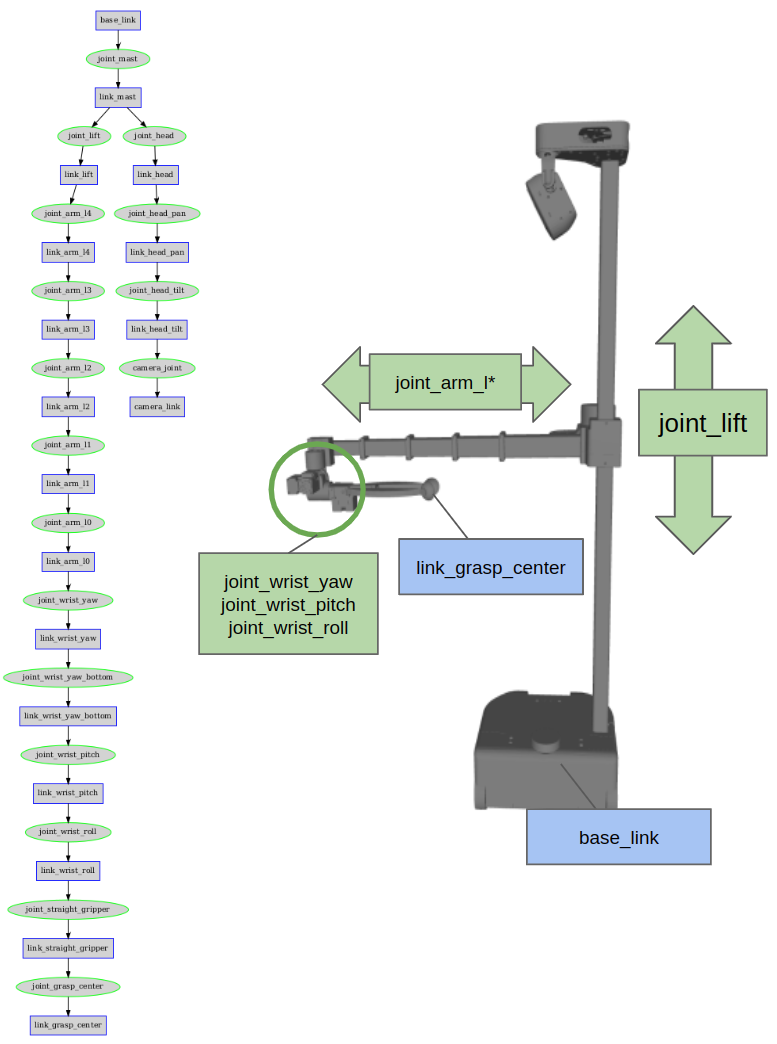

Let's formalize some commonly used terminology when discussing these problems. Often, you'll hear the set of joint positions for a robot called a "configuration". For Stretch, it's common to send the robot into its stow "configuration" using `stretch_robot_stow.py`, where the arm folds into its base footprint. Another phrase you'll see is "configuration space" (a.k.a. "C space") vs "task space". As you might expect, the "configuration space" is the set of possible configurations the robot can take, where as the "task space" is often defined in world coordinates and is useful for thinking about accomplishing tasks in the world (e.g. move that mug from the table to the sink). "Space" actually has mathematical meaning here; the "task space" is often defined as SE(3) or special euclidean group in 3 dimensions, which is a concept from Lie Algebra. There are better tutorials/books available on Lie Algebra, but what this means is you ultimately need 6 numbers to define a pose in the task space: x, y, and z, which constitutes a point in 3D space, and roll, pitch, and yaw, which orients a frame fixed at that point. Meanwhile, you need `N = <num joints>` numbers to define a configuration in the C space. Then, forward and inverse kinematics becomes these 2 equations:

<center>
Where $q \in \mathbb{R}^{N}$ and $x \in \mathbf{SE}(3)$
</center>
<center>
Forward Kinematics: $x = f(q)$
</center>
<center>
Inverse Kinematics: $q = f^{-1}(x)$
</center>

For simple robots, it's possible to solve $f^{-1}$ analytically. For example, you could imagine doing the trigonometry to calculate the shoulder and elbow angles for a human arm to achieve a target pose. For complex robots, it's more common to approach IK via an iterative approach, often the pseudo-inverse Jacobian method. In the following example, we'll take the simplified example of a Stretch projected into a bird's eye 2D world to show how the pseudo-inverse method works.

Projecting Stretch onto SE2 (taking a bird’s eye view), we’d see a differential drive mobile base, a prismatic joint (telescoping arm), and a revolute joint (yaw gripper joint).

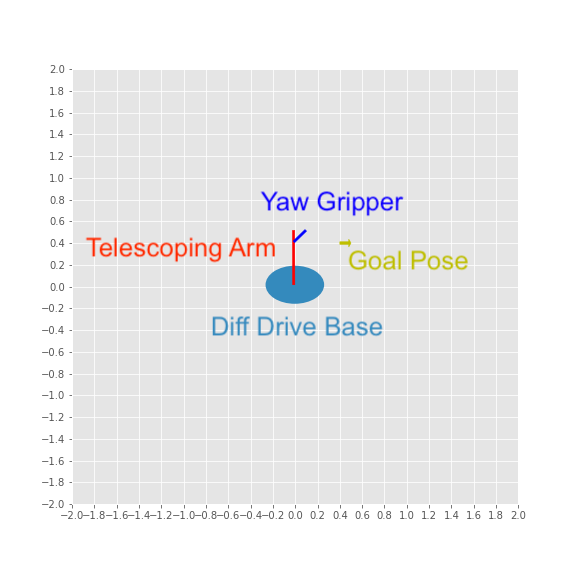

In this simplified version of Stretch, our joint state vector is composed of the SE2 pose (x, y, and heading) of the base, and the arm joints (s1 and theta1).

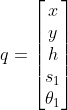

We start by defining the forward kinematics for this robot. FK to the end effector pose is given as:

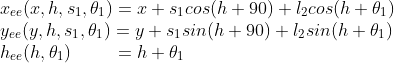

In the pseudo-inverse method, we take the derivative of forward kinematics, $x = f(q)$. When you take the partial derivatives of the FK system of equations, it is called the "Jacobian", $J$. The result is: $\dot{x} = J\dot{q}$. Instead of taking the partials by hand, we'll use [sympy](https://docs.sympy.org/latest/index.html), a symbolic computation library to find the [Jacobian](https://docs.sympy.org/latest/modules/matrices/matrices.html#sympy.matrices.matrices.MatrixCalculus.jacobian).

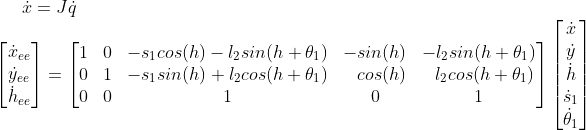

But we want to know $\dot{q}$, so this is where we take the pseudo-inverse (also using [sympy](https://docs.sympy.org/latest/modules/matrices/matrices.html#sympy.matrices.matrices.MatrixBase.pinv)) to get $\dot{q} = J^{+}\dot{x}$. Now we can iteratively change $q$ by $\dot{q}$ until we've converged on the original target $x$. Here's an animation that shows what converging on a solution looks like for three different target end-effector poses:

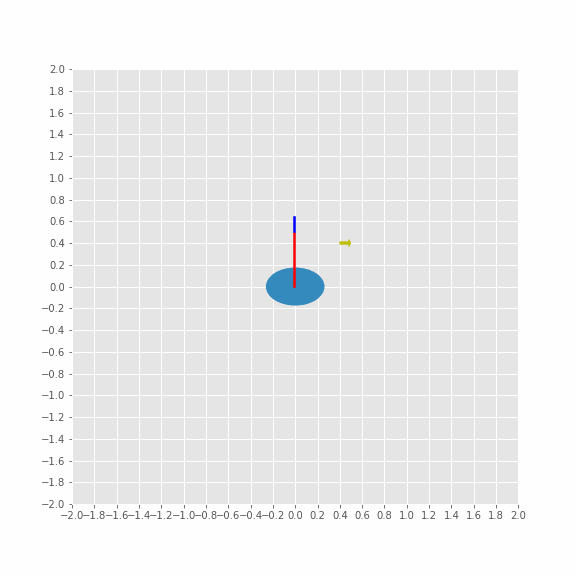

In the example above, each link starts where the previous link began. In reality, Stretch's joints take physical space, so there's always a offset that needs to be added to the forward kinematic equations. In the next section, we'll pass Stretch's actual URDF to an inverse kinematics library called IKPy so that it can perform the pseudo-inverse method with realistic offsets for us.

## IK for cartesian Stretch

In general, "differential drive" mobile bases (i.e. two wheels side by side) like the one used in Stretch can make it hard to converge to a solution in the pseudo-inverse method. Furthermore, you might want to steer the robot around obstacles in the environment, which the pseudo-inverse method won't do by default. For these reasons, it's better to use a different planning approach (e.g. [RRT](https://towardsdatascience.com/how-does-a-robot-plan-a-path-in-its-environment-b8e9519c738b) or potential fields) when navigating Stretch through the environment.

One planning paradigm that is effective with Stretch is to:

 1. Navigate Stretch within vicinity of where the manipulation is going to take place (e.g. using the [NavStack](https://github.com/hello-robot/stretch_ros/tree/dev/noetic/stretch_navigation))
 2. Align Stretch perpendicular to the surface where the manipulation is going to take place (tables, walls, etc. have a flat horizontal edge you can easily align with)
 3. Treat the mobile base as a prismatic joint that can only translate back and forth. This becomes your "x axis". Paired with the lift as a "z axis", and arm as a "y axis", you have a cartesian manipulator that can effectively manipulate on a surface. This is where you might introduce the pseudo-inverse IK method.

In this tutorial, we'll assume the robot is already near and aligned with the manipulation scene. We'll modify Stretch's chain to include a virtual prismatic (i.e. sliding) joint for the translating mobile base. We'll demonstrate writing on a whiteboard using IK on this chain.

### Stretch's URDF
URDFs (or Unified Robot Description Format) are used in robotics to encode a robot's chain. IKPy imports URDFs in order to calculate IK for a robot. Before we create a chain in IKPy, we'll look at Stretch's URDF.

Stretch's URDF lives in two places: in your ROS1 Catkin Workspace (to use with ROS software) and in your "stretch_user" directory (to use with non-ROS software). A few things to note about Stretch's URDF:
 - It is calibrated using a [calibration software](https://github.com/hello-robot/stretch_ros/tree/dev/noetic/stretch_calibration), where the robot looks at the 5 AruCo markers on itself and optimizes to determine link-to-link offsets. This makes each Stretch's URDF slightly different. Without this calibration, you'll notice a "hand-eye offset", a common problem in robotics where perception and proprioception don't agree.
 - It is supposed to reflect the end-effector attached to the robot. Stretch is designed to make it easy to swap the tool at the end of the arm, so it's pretty common to swap the end-effector hardware and forget to recompile the URDF to reflect the new end-effector's link/joints. The two most common end-effectors for Stretch are the [Stretch Gripper](https://hello-robot.com/stretch-2#stretch-compliant-gripper-re2) and [Dex Wrist](https://hello-robot.com/stretch-dex-wrist).
 - It may be missing the `link_grasp_center` link. We discovered in Feb 2023 that this link was missing from some URDFs, so you may need to recompile your URDF. We will be doing IK for this link in this tutorial.

Let's visualize the URDF from the "stretch_user" directory now to confirm it has the right end-effector and necessary links. If you find an issue, follow [these instructions to recompile your urdf](https://github.com/hello-robot/stretch_ros/blob/dev/noetic/stretch_description/README.md#changing-the-tool) in the ROS1 Catkin workspace and then [these instructions to export it](https://github.com/hello-robot/stretch_ros/blob/dev/noetic/stretch_description/README.md#exporting-a-urdf) over to "stretch_user".

In [3]:
import ikpy.urdf.utils
import pathlib
import stretch_body.hello_utils as hu
from IPython import display
import ipywidgets as widgets

Stretch Body's `hello_utils` module has a function called `get_fleet_directory()` that returns the "stretch_user" directory.

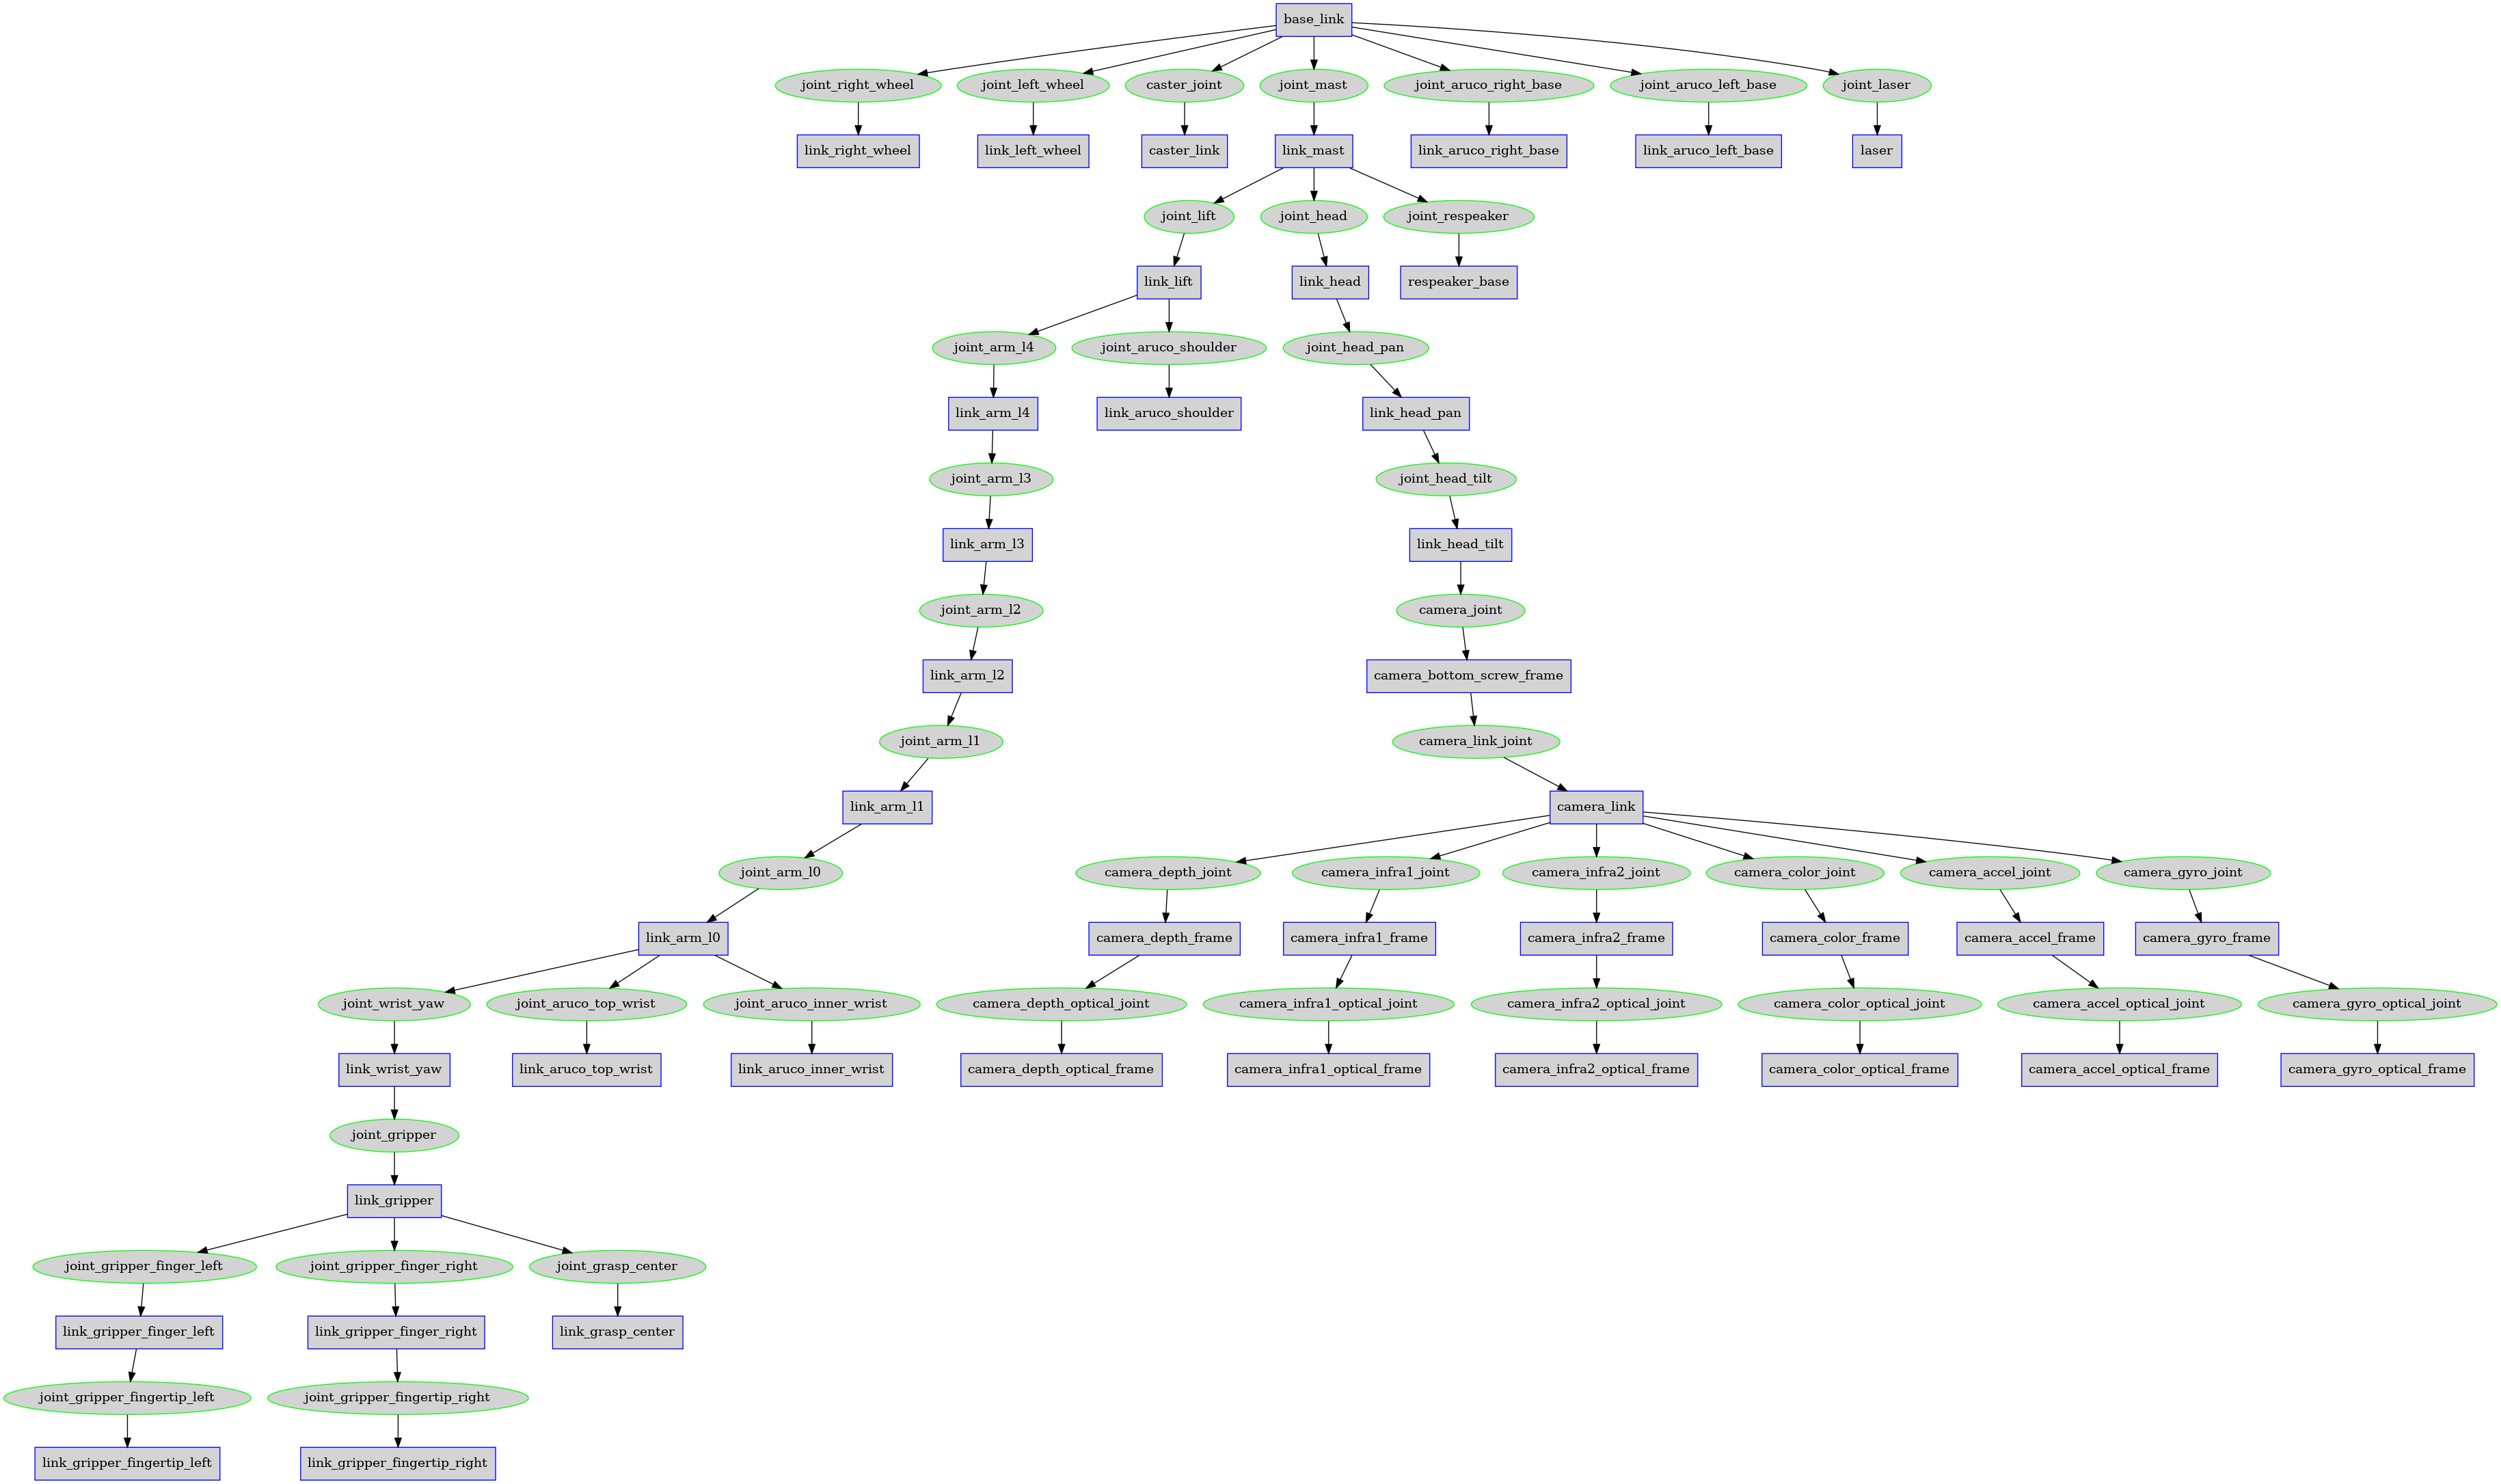

In [4]:
urdf_path = str((pathlib.Path(hu.get_fleet_directory()) / 'exported_urdf' / 'stretch.urdf').absolute())
tree = ikpy.urdf.utils.get_urdf_tree(urdf_path, "base_link")[0]
display.display_png(tree)

The image above might be too small to read. We'll render it again as an SVG so you can scroll through the image.

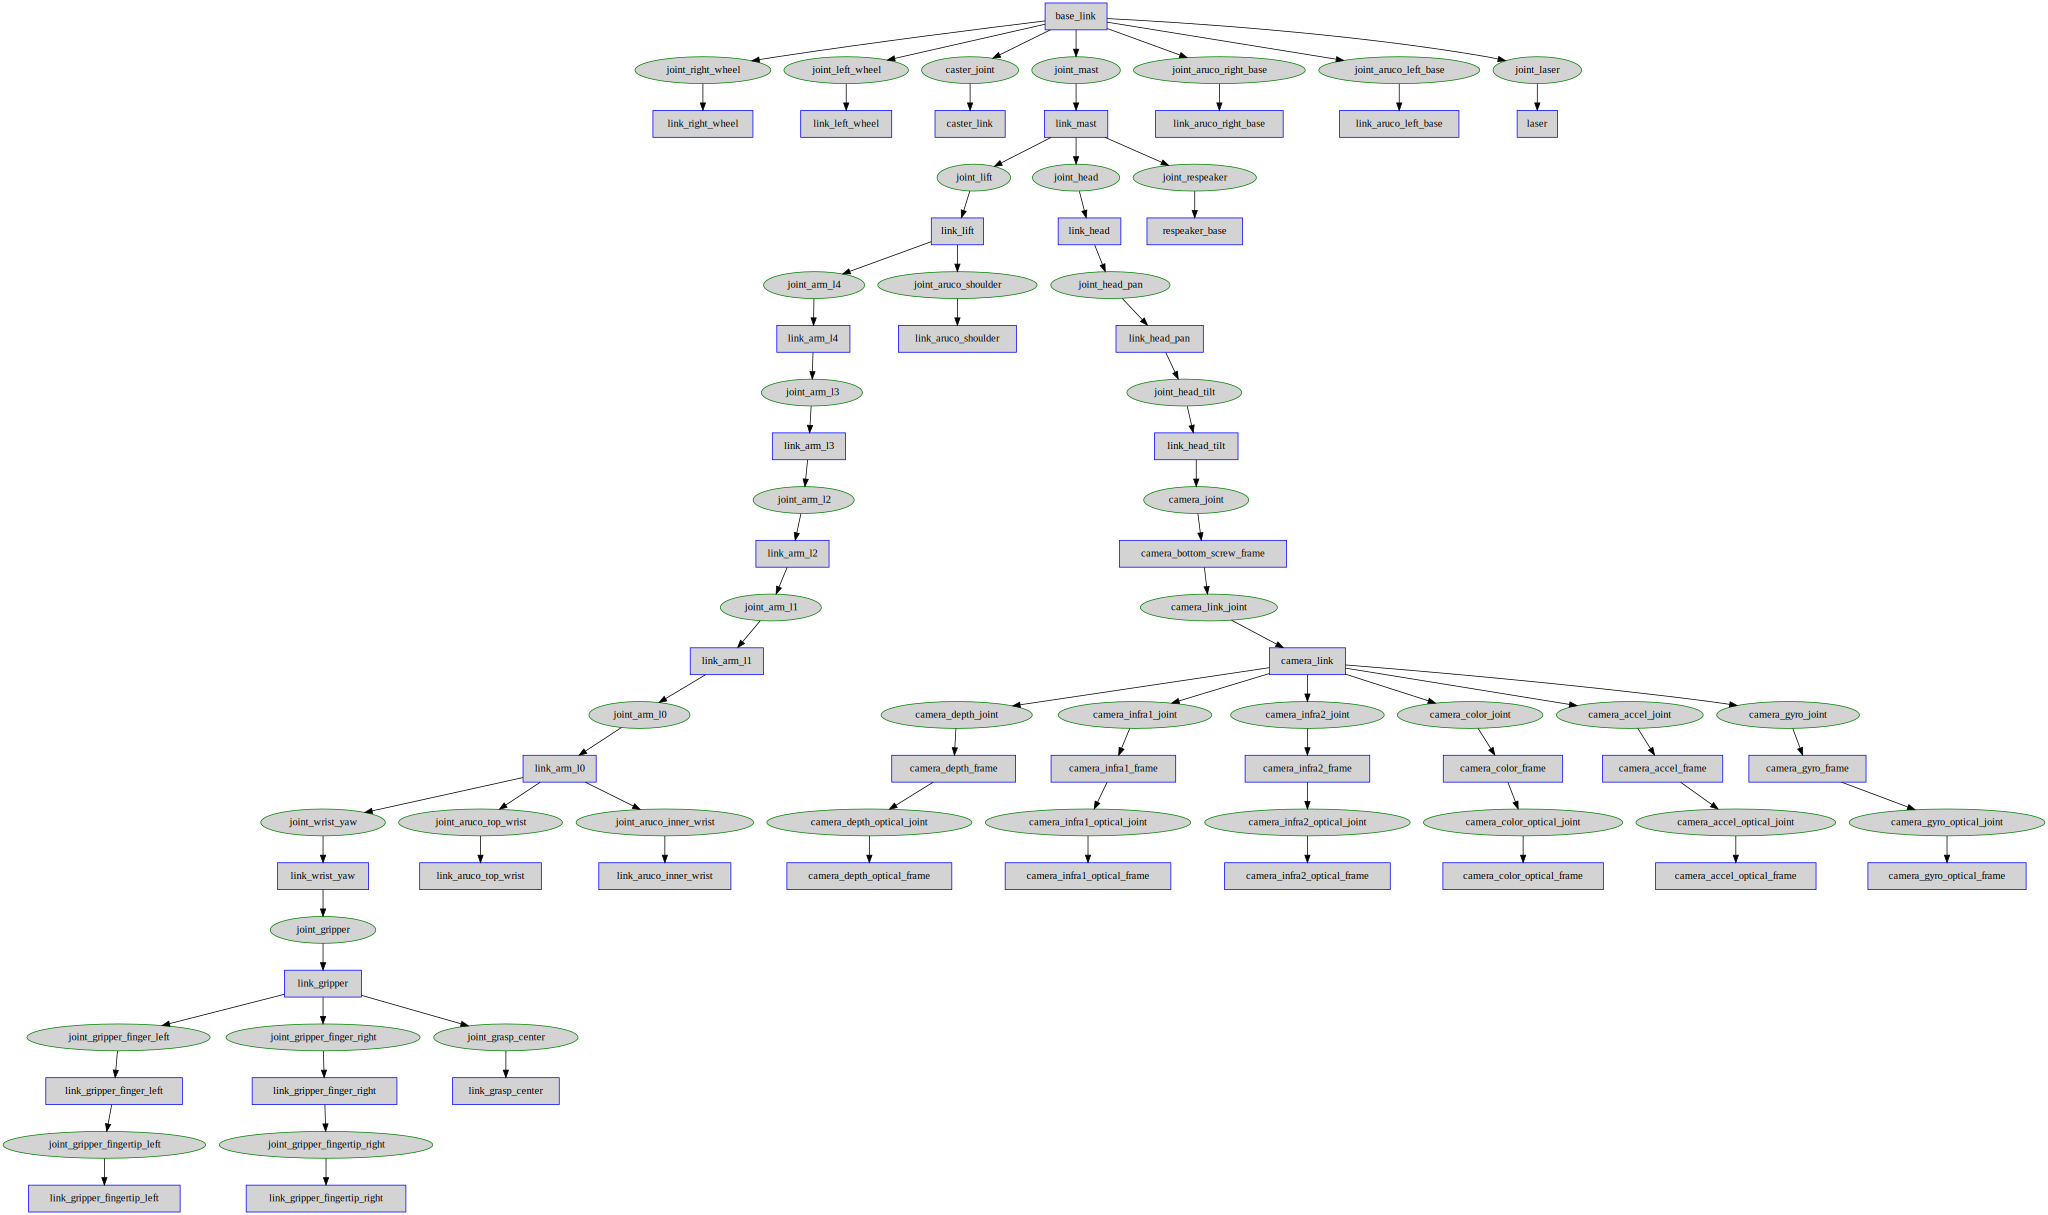

In [5]:
display.display_svg(tree)

You'll notice Stretch's URDF isn't a single chain from base link to end-effector link. Instead, it's a tree with multiple chains that include every part of the robot. For example, if we instead wanted to do IK for Stretch's head, we would be interested in the chain from `base_link` to `camera_link`. In the tree above, ensure there is a chain from `base_link` to `link_grasp_center`. If the grasp center link is missing, you'll need to recompile your URDF.

In [6]:
f"Your robot is equipped with the '{robot.end_of_arm.name}' end-effector"

"Your robot is equipped with the 'tool_stretch_gripper' end-effector"

If your robot is equipped with the 'tool_stretch_gripper' end-effector, your chain should look something like:
```
base_link -> link_mast -> link_lift -> link_arml0-4 -> link_wrist_yaw -> link_gripper -> link_grasp_center
```

If your robot is equipped with the 'tool_stretch_dex_wrist' end-effector, your chain should look something like:
```
base_link -> link_mast -> link_lift -> link_arml0-4 -> link_wrist_yaw -> link_wrist_yaw_bottom -> link_wrist_pitch -> link_wrist_roll -> link_straight_gripper -> link_grasp_center
```

If your robot is equipped with a different tool, it won't have the links necessary for the rest of the tutorial. Swap the end-effector on your robot and recompile the URDF.

To get a sense for where these links reside on the robot, I recommend visualizing a 3d model of the robot with the links superimposed. An easy way to do this is to use ROS and Rviz. On a Stretch, open a new terminal and run:

```
roslaunch stretch_description display.launch
```

You should see a window like this:

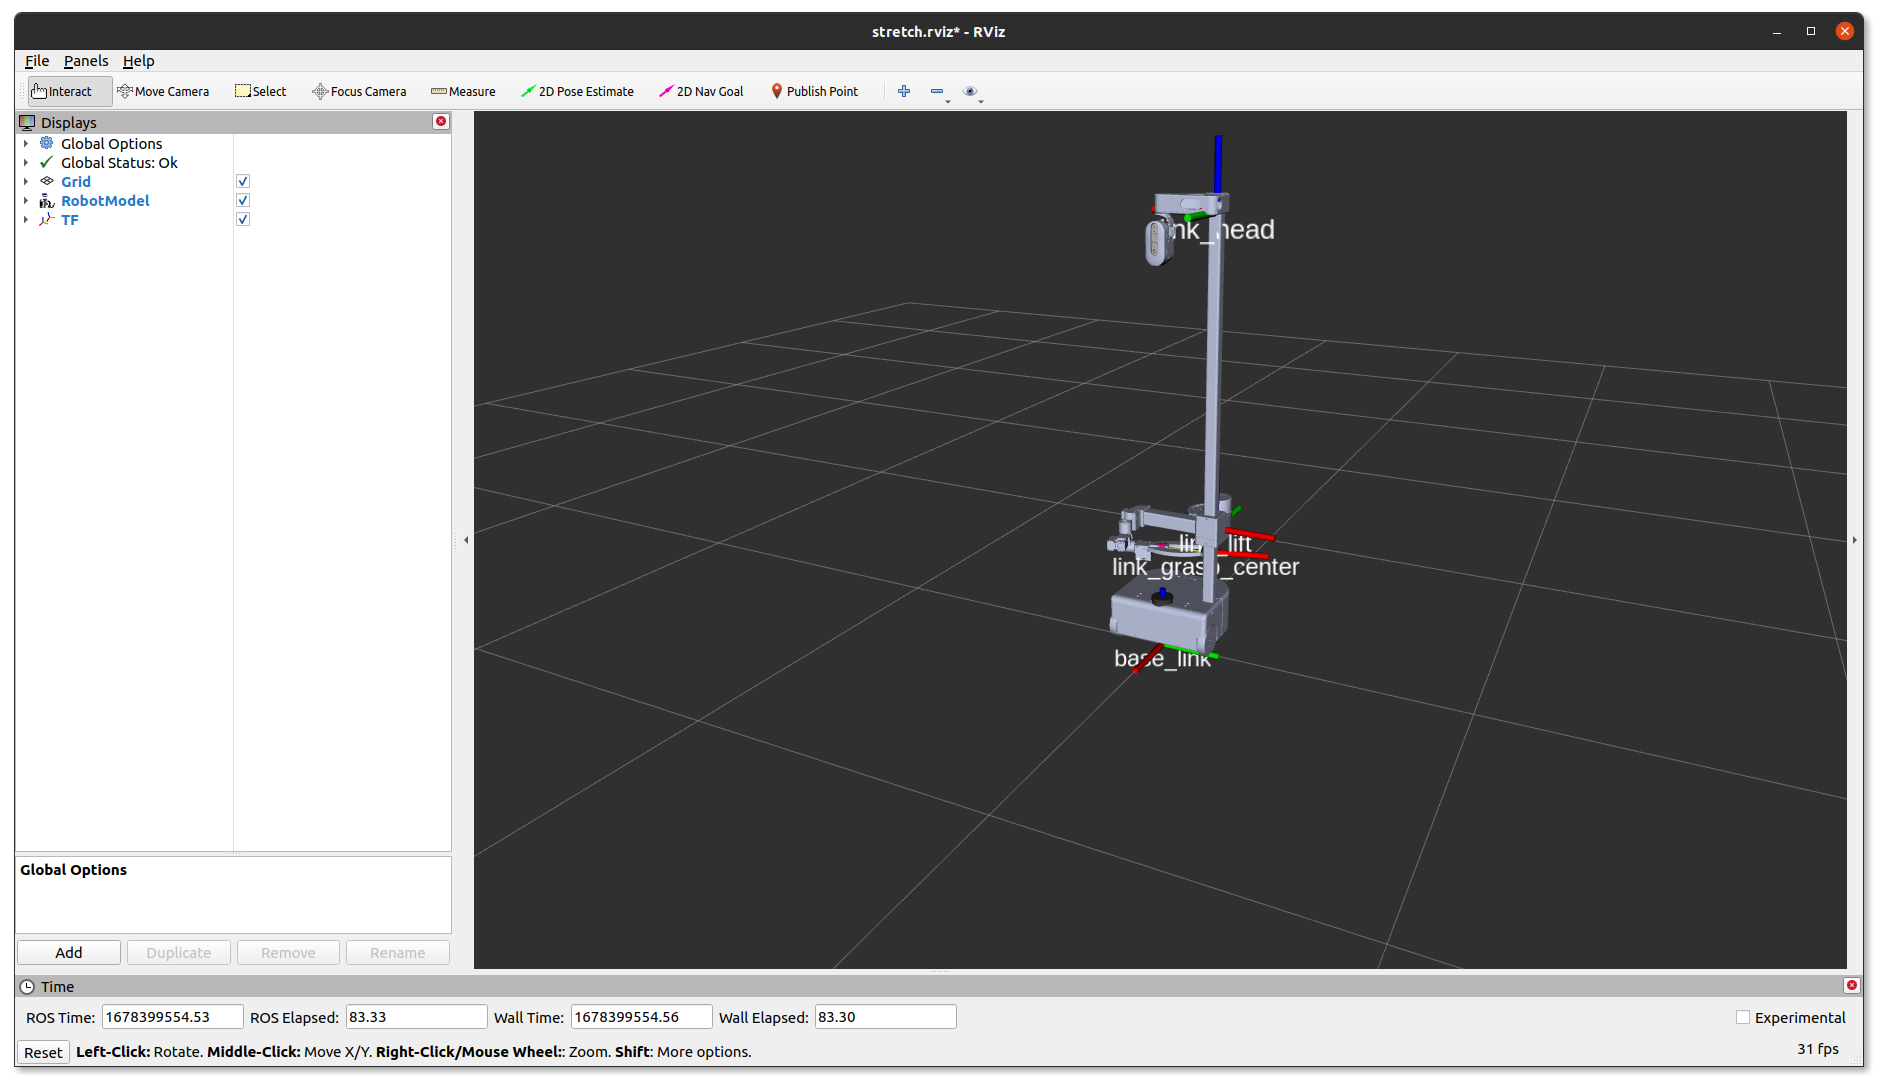

### Modifications to the URDF

IKPy only supports ranged joints, which means Stretch's wheels which spin continuously cannot be included in the URDF. We'll replace the left and right wheel joints with a virtual prismatic joint called `joint_base_translation`. We'll also remove all link/joints that comprise other chains besides the one from `base_link` to `link_grasp_center`. We'll use the [urdfpy](https://github.com/mmatl/urdfpy) library to make these modifications to Stretch's URDF.

In [7]:
import urdfpy
import numpy as np

In [8]:
original_urdf = urdfpy.URDF.load(urdf_path)
print(f"name: {original_urdf.name}")
print(f"num links: {len(original_urdf.links)}")
print(f"num joints: {len(original_urdf.joints)}")

name: stretch
num links: 42
num joints: 41


/home/hello-robot/.local/lib/python3.8/site-packages/urdfpy/urdf.py:2169: RuntimeWarning: invalid value encountered in true_divide
  value = value / np.linalg.norm(value)


Remove unnecessary links/joints.

In [9]:
modified_urdf = original_urdf.copy()
names_of_links_to_remove = ['link_right_wheel', 'link_left_wheel', 'caster_link', 'link_gripper_finger_left', 'link_gripper_fingertip_left', 'link_gripper_finger_right', 'link_gripper_fingertip_right', 'link_head', 'link_head_pan', 'link_head_tilt', 'link_aruco_right_base', 'link_aruco_left_base', 'link_aruco_shoulder', 'link_aruco_top_wrist', 'link_aruco_inner_wrist', 'camera_bottom_screw_frame', 'camera_link', 'camera_depth_frame', 'camera_depth_optical_frame', 'camera_infra1_frame', 'camera_infra1_optical_frame', 'camera_infra2_frame', 'camera_infra2_optical_frame', 'camera_color_frame', 'camera_color_optical_frame', 'camera_accel_frame', 'camera_accel_optical_frame', 'camera_gyro_frame', 'camera_gyro_optical_frame', 'laser', 'respeaker_base']
links_to_remove = [l for l in modified_urdf._links if l.name in names_of_links_to_remove]
for lr in links_to_remove:
    modified_urdf._links.remove(lr)
names_of_joints_to_remove = ['joint_right_wheel', 'joint_left_wheel', 'caster_joint', 'joint_gripper_finger_left', 'joint_gripper_fingertip_left', 'joint_gripper_finger_right', 'joint_gripper_fingertip_right', 'joint_head', 'joint_head_pan', 'joint_head_tilt', 'joint_aruco_right_base', 'joint_aruco_left_base', 'joint_aruco_shoulder', 'joint_aruco_top_wrist', 'joint_aruco_inner_wrist', 'camera_joint', 'camera_link_joint', 'camera_depth_joint', 'camera_depth_optical_joint', 'camera_infra1_joint', 'camera_infra1_optical_joint', 'camera_infra2_joint', 'camera_infra2_optical_joint', 'camera_color_joint', 'camera_color_optical_joint', 'camera_accel_joint', 'camera_accel_optical_joint', 'camera_gyro_joint', 'camera_gyro_optical_joint', 'joint_laser', 'joint_respeaker']
joints_to_remove = [l for l in modified_urdf._joints if l.name in names_of_joints_to_remove]
for jr in joints_to_remove:
    modified_urdf._joints.remove(jr)
print(f"name: {modified_urdf.name}")
print(f"num links: {len(modified_urdf.links)}")
print(f"num joints: {len(modified_urdf.joints)}")

name: stretch
num links: 11
num joints: 10


Add virtual base joint. It will have range from -1m to 1m.

In [10]:
joint_base_translation = urdfpy.Joint(name='joint_base_translation',
                                      parent='base_link',
                                      child='link_base_translation',
                                      joint_type='prismatic',
                                      axis=np.array([1.0, 0.0, 0.0]),
                                      origin=np.eye(4, dtype=np.float64),
                                      limit=urdfpy.JointLimit(effort=100.0, velocity=1.0, lower=-1.0, upper=1.0))
modified_urdf._joints.append(joint_base_translation)
link_base_translation = urdfpy.Link(name='link_base_translation',
                                    inertial=None,
                                    visuals=None,
                                    collisions=None)
modified_urdf._links.append(link_base_translation)

# amend the chain
for j in modified_urdf._joints:
    if j.name == 'joint_mast':
        j.parent = 'link_base_translation'
print(f"name: {modified_urdf.name}")
print(f"num links: {len(modified_urdf.links)}")
print(f"num joints: {len(modified_urdf.joints)}")

name: stretch
num links: 12
num joints: 11


Save it to the "/tmp" directory. This will be deleted the next time you reboot the robot.

In [11]:
iktuturdf_path = "/tmp/iktutorial/stretch.urdf"
modified_urdf.save(iktuturdf_path)

Here's what the new cartesian Stretch URDF tree looks like.

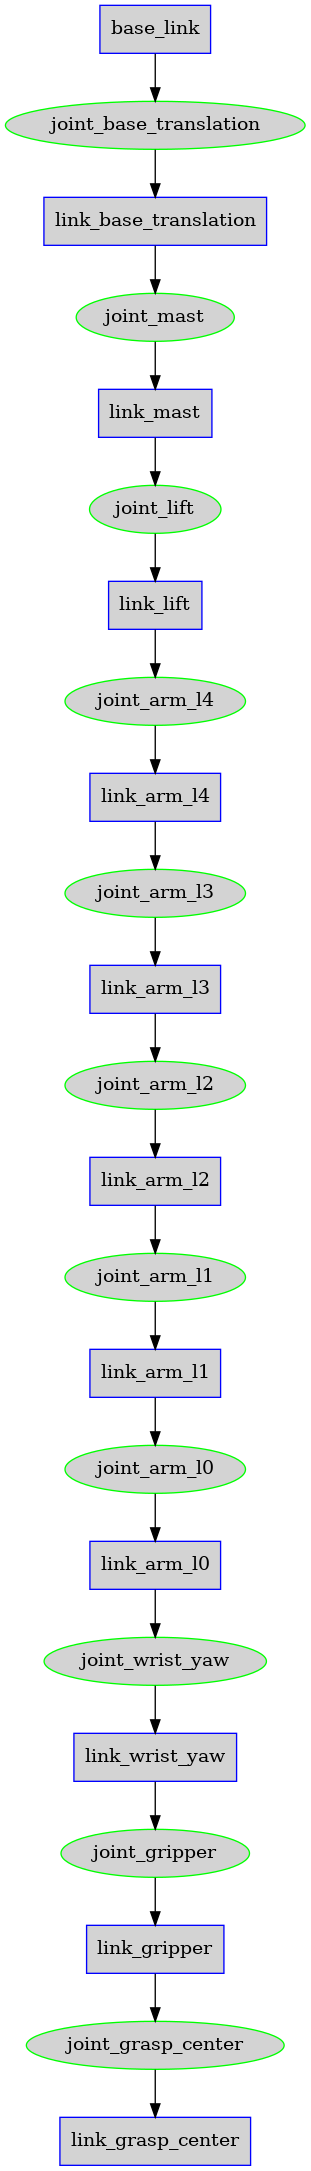

In [12]:
tree = ikpy.urdf.utils.get_urdf_tree(iktuturdf_path, "base_link")[0]
display.display_png(tree)

### Creating the chain

With our new cartesian URDF of Stretch, let's create an IKPy chain.

In [13]:
import ikpy.chain

In [14]:
chain = ikpy.chain.Chain.from_urdf_file(iktuturdf_path)
chain

/home/hello-robot/.local/lib/python3.8/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint joint_mast is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored
  warnings.warn("Joint {} is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored".format(joint.attrib["name"]))
/home/hello-robot/.local/lib/python3.8/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint joint_arm_l4 is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored
  warnings.warn("Joint {} is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored".format(joint.attrib["name"]))
/home/hello-robot/.local/lib/python3.8/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint joint_gripper is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis

Kinematic chain name=chain links=['Base link', 'joint_base_translation', 'joint_mast', 'joint_lift', 'joint_arm_l4', 'joint_arm_l3', 'joint_arm_l2', 'joint_arm_l1', 'joint_arm_l0', 'joint_wrist_yaw', 'joint_gripper', 'joint_grasp_center'] active_links=[ True  True  True  True  True  True  True  True  True  True  True  True]

IKPy gives us an overview of the chain at `chain.links`.

In [15]:
chain.links

[Link name=Base link bounds=(-inf, inf),
 URDF Link joint_base_translation :
     Type : prismatic
     Bounds : (-1.0, 1.0)
     Origin Translation : [0. 0. 0.]
     Origin Orientation : [ 0. -0.  0.]
     Rotation : None
     Translation: [1. 0. 0.],
 URDF Link joint_mast :
     Type : fixed
     Bounds : (-inf, inf)
     Origin Translation : [-0.06994291  0.13543556  0.03831914]
     Origin Orientation : [ 1.5432051  -0.03281277  0.01641182]
     Rotation : None
     Translation: None,
 URDF Link joint_lift :
     Type : prismatic
     Bounds : (0.0, 1.1)
     Origin Translation : [-0.03692171  0.1654712  -0.00034165]
     Origin Orientation : [-1.57079633e+00  1.56154314e+00 -6.29420044e-13]
     Rotation : None
     Translation: [0. 0. 1.],
 URDF Link joint_arm_l4 :
     Type : fixed
     Bounds : (-inf, inf)
     Origin Translation : [-0.26226295 -0.00368591  0.00492782]
     Origin Orientation : [ 1.58020788 -0.00439846 -1.59420289]
     Rotation : None
     Translation: None,
 

### Current robot configuration

We'll need to be able to read the current configuration the robot is in. Let's define `get_current_configuration(tool)` to do this.

In [16]:
def get_current_configuration(tool):
    def bound_range(name, value):
        names = [l.name for l in chain.links]
        index = names.index(name)
        bounds = chain.links[index].bounds
        return min(max(value, bounds[0]), bounds[1])

    if tool == 'tool_stretch_gripper':
        q_base = 0.0
        q_lift = bound_range('joint_lift', robot.lift.status['pos'])
        q_arml = bound_range('joint_arm_l0', robot.arm.status['pos'] / 4.0)
        q_yaw = bound_range('joint_wrist_yaw', robot.end_of_arm.status['wrist_yaw']['pos'])
        return [0.0, q_base, 0.0, q_lift, 0.0, q_arml, q_arml, q_arml, q_arml, q_yaw, 0.0, 0.0]
    elif tool == 'tool_stretch_dex_wrist':
        q_base = 0.0
        q_lift = bound_range('joint_lift', robot.lift.status['pos'])
        q_arml = bound_range('joint_arm_l0', robot.arm.status['pos'] / 4.0)
        q_yaw = bound_range('joint_wrist_yaw', robot.end_of_arm.status['wrist_yaw']['pos'])
        q_pitch = bound_range('joint_wrist_pitch', robot.end_of_arm.status['wrist_pitch']['pos'])
        q_roll = bound_range('joint_wrist_roll', robot.end_of_arm.status['wrist_roll']['pos'])
        return [0.0, q_base, 0.0, q_lift, 0.0, q_arml, q_arml, q_arml, q_arml, q_yaw, 0.0, q_pitch, q_roll, 0.0, 0.0]

In [17]:
robot.stow()
get_current_configuration(tool=robot.end_of_arm.name)

--------- Stowing Arm ----
--------- Stowing Wrist Yaw ----
--------- Stowing Gripper ----
--------- Stowing Lift ----


[0.0,
 0.0,
 0.0,
 0.23057667699522752,
 0.0,
 8.98041255162881e-07,
 8.98041255162881e-07,
 8.98041255162881e-07,
 8.98041255162881e-07,
 3.399684921151552,
 0.0,
 0.0]

The stow configuration should look like [0.0, 0.0, 0.0, ~0.2, 0.0, 0.0, 0.0, 0.0, 0.0, ~3.4, optional pitch and roll joints, 0.0, 0.0]

### Solving IK for a goal point

IKPy fixes the world frame at the robot's `base_link`, so all goals are are defined with respect to the base link. We'll start by asking IKPy to calculate a configuration for the robot that achieves a target 3D point, without any orientation constraints.

In [18]:
target_point = [-0.043, -0.441, 0.654]

`inverse_kinematics()` performs the pseudo-inverse IK method. Be sure to pass it the robot's current configuration as the initial position, or the optimization might not converge.

In [19]:
q_init = get_current_configuration(tool=robot.end_of_arm.name)
q_soln = chain.inverse_kinematics(target_point, initial_position=q_init)
q_soln

array([ 0.00000000e+00,  1.48620987e-01, -3.99869844e+02,  6.05487534e-01,
       -2.68039966e-01,  1.12576414e-01,  1.12576414e-01,  1.12576414e-01,
        1.12576414e-01,  3.94686412e+00,  0.00000000e+00,  0.00000000e+00])

Passing the IK solution through FK allows us to compute the difference between our target pose and where the solution would place the end-effector.

In [20]:
# calculate the error
np.linalg.norm(chain.forward_kinematics(q_soln)[:3, 3] - target_point)

4.063425962123409e-10

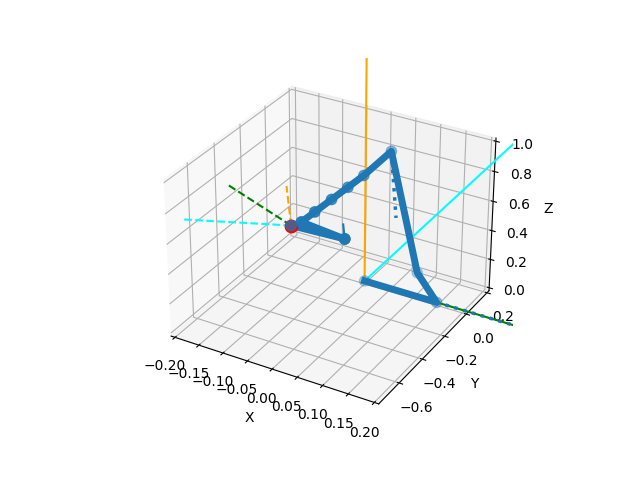

In [21]:
%matplotlib widget
import ikpy.utils.plot as plot_utils
import matplotlib.pyplot as plt
fig, ax = plot_utils.init_3d_figure()
plt.xlim(-0.2, 0.2)
plt.ylim(-0.75, 0.2)
ax.set_zlim(0.0, 1.0)
chain.plot(q_soln, ax, target=target_point)

This plot above can be difficult to understand since it hasn't been annotated. Here's an annotated screenshot:

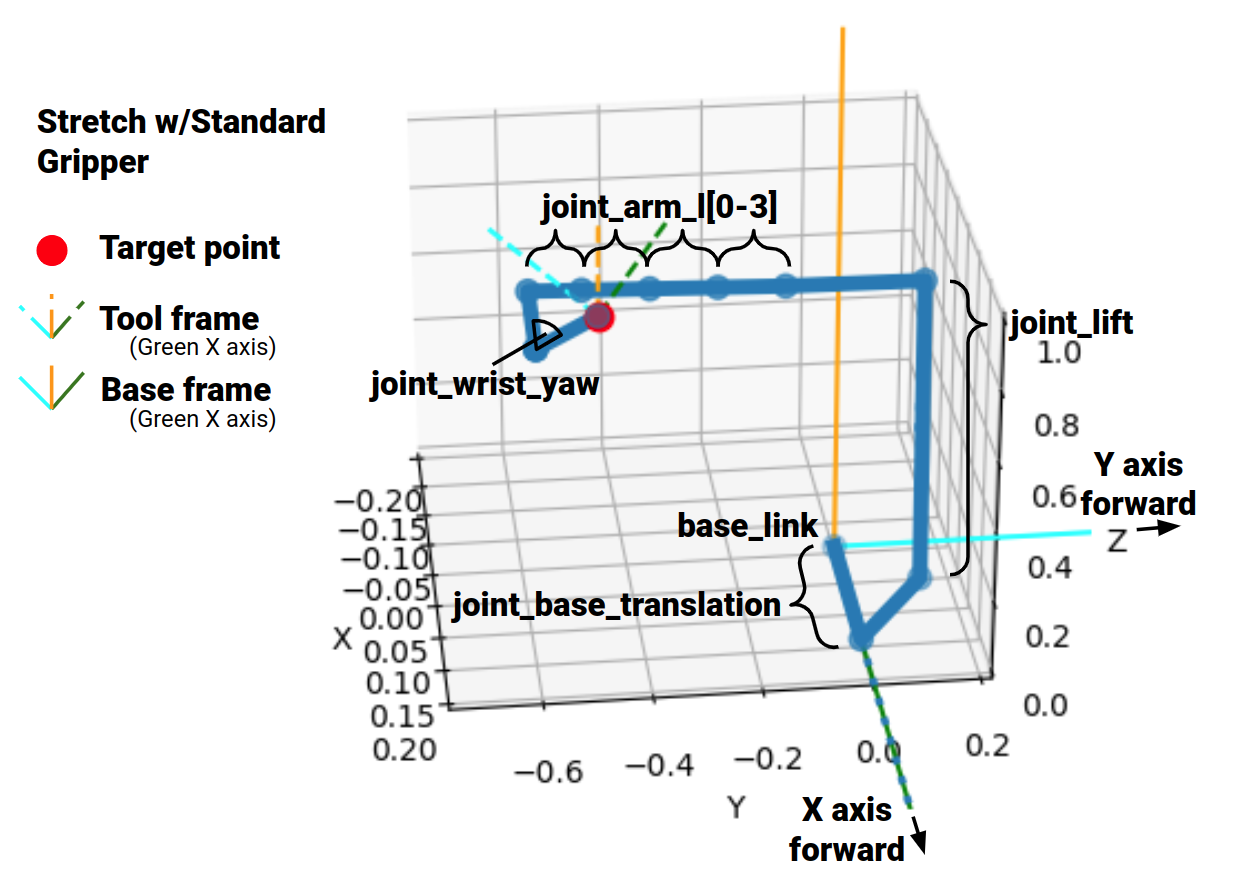

### Solving IK for a goal pose

Now we know how to use IKPy to solve for a configuration that gets us to a target 3D point. However, notice in the previous plot how IKPy's solution is unnecessarily complicated. It has the robot extending its arm out and reaching back with the yaw joint to get to the target point. A simpler solution would be to retract the arm in and extend the yaw outwards to achieve the same point. In this section, we'll add an orientation constraint to the target point, thereby making it a target 3D pose. The orientation constraint will give a solution that has the gripper pointing away from the robot.

In [22]:
target_point = [-0.043, -0.441, 0.654]
target_orientation = ikpy.utils.geometry.rpy_matrix(0.0, 0.0, -np.pi/2)
pretarget_orientation = ikpy.utils.geometry.rpy_matrix(0.0, 0.0, 0.0)

IKPy often has trouble with the revolute joints at the end of the arm, so we use a trick here to target an orientation that's easier to converge to (i.e. pretarget orientation), and use the pretarget solution to jump start the optimization to the real target orientation. In this example, we're providing a constraint for all three rotational axes, so `orientation_mode` must be set to "all". It's also possible to constraint just one axis. See [the docs](https://ikpy.readthedocs.io/en/latest/inverse_kinematics.html) for more details.

In [23]:
q_init = get_current_configuration(tool=robot.end_of_arm.name)
q_mid = chain.inverse_kinematics(target_point, pretarget_orientation, orientation_mode='all', initial_position=q_init)
q_soln = chain.inverse_kinematics(target_point, target_orientation, orientation_mode='all', initial_position=q_mid)
with np.printoptions(precision=3, suppress=True):
    print(q_soln)

[    0.       -0.003  -341.004     0.6   -1917.661     0.025     0.025
     0.025     0.025     0.016     0.        0.   ]


In [24]:
# calculate the error
np.linalg.norm(chain.forward_kinematics(q_soln)[:3, 3] - target_point)

2.9180372816044463e-13

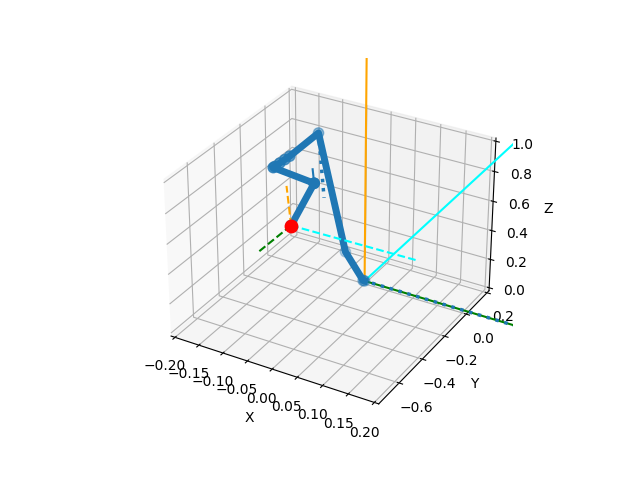

In [25]:
fig, ax = plot_utils.init_3d_figure()
plt.xlim(-0.2, 0.2)
plt.ylim(-0.75, 0.2)
ax.set_zlim(0.0, 1.0)
chain.plot(q_soln, ax, target=target_point)

### Move robot to configuration

We can now use Stretch Body to execute the configuration IKPy solved for in order to get to our target point. Let's define `move_to_configuration(tool, q)` to do this.

In [26]:
def move_to_configuration(tool, q):
    if tool == 'tool_stretch_gripper':
        q_base = q[1]
        q_lift = q[3]
        q_arm = q[5] + q[6] + q[7] + q[8]
        q_yaw = q[9]
        robot.base.translate_by(q_base)
        robot.lift.move_to(q_lift)
        robot.arm.move_to(q_arm)
        robot.end_of_arm.move_to('wrist_yaw', q_yaw)
        robot.push_command()
    elif tool == 'tool_stretch_dex_wrist':
        q_base = q[1]
        q_lift = q[3]
        q_arm = q[5] + q[6] + q[7] + q[8]
        q_yaw = q[9]
        q_pitch = q[11]
        q_roll = q[12]
        robot.base.translate_by(q_base)
        robot.lift.move_to(q_lift)
        robot.arm.move_to(q_arm)
        robot.end_of_arm.move_to('wrist_yaw', q_yaw)
        robot.end_of_arm.move_to('wrist_pitch', q_pitch)
        robot.end_of_arm.move_to('wrist_roll', q_roll)
        robot.push_command()

In [27]:
robot.stow()
move_to_configuration(tool=robot.end_of_arm.name, q=q_soln)

--------- Stowing Arm ----
--------- Stowing Wrist Yaw ----
--------- Stowing Gripper ----
--------- Stowing Lift ----


[INFO] [robot_monitor]: Wrist single tap: 11


The robot should move to its stow configuration first, and then move to the gripper out configuration we previously solved for.

### Tying it together

Finally, we can wrap IKPy's calculations and `move_to_configuration()` to solve and execute to a target goal. Let's define `move_to_grasp_goal(target_pose)` to do this.

In [28]:
def move_to_grasp_goal(target_pose, pretarget_pose=None, plot_prompt=False):
    q_init = get_current_configuration(tool=robot.end_of_arm.name)
    if pretarget_pose is not None:
        q_init = chain.inverse_kinematics_frame(pretarget_pose, orientation_mode='all', initial_position=q_init)
    q_soln = chain.inverse_kinematics_frame(target_pose, orientation_mode='all', initial_position=q_init)
    if plot_prompt:
        fig, ax = plot_utils.init_3d_figure()
        plt.xlim(-0.2, 0.2)
        plt.ylim(-0.75, 0.2)
        ax.set_zlim(0.0, 1.0)
        chain.plot(q_soln, ax, target=target_pose[:3, 3])
        plot_utils.show_figure()

        button = widgets.Button(description="Execute move")
        output = widgets.Output()
        display.display(button, output)
        def on_button_clicked(b):
            with output:
                err = np.linalg.norm(chain.forward_kinematics(q_soln)[:3, 3] - target_pose[:3, 3])
                if not np.isclose(err, 0.0, atol=1e-2):
                    print("IKPy did not find a valid solution")
                    return
                move_to_configuration(tool=robot.end_of_arm.name, q=q_soln)
                return q_soln
        button.on_click(on_button_clicked)
    else:
        err = np.linalg.norm(chain.forward_kinematics(q_soln)[:3, 3] - target_pose[:3, 3])
        if not np.isclose(err, 0.0, atol=1e-2):
            print("IKPy did not find a valid solution")
            return
        move_to_configuration(tool=robot.end_of_arm.name, q=q_soln)
        return q_soln

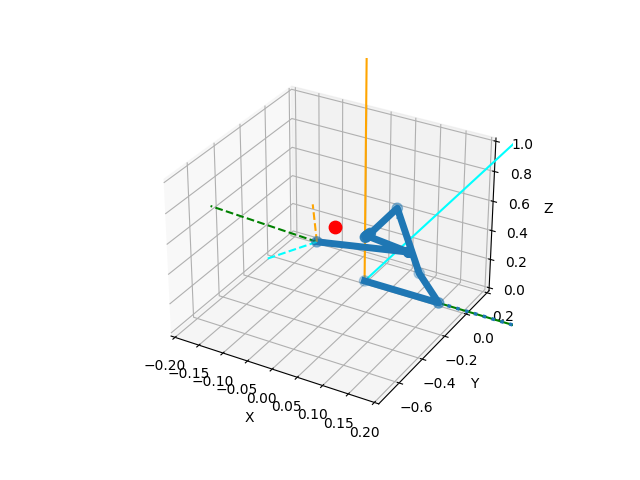

Button(description='Execute move', style=ButtonStyle())

Output()

In [29]:
goal = np.array([[-0.23815889, -0.97049054, -0.03779491, -0.07488198],
       [ 0.97087237, -0.23894213,  0.01770604,  0.05378699],
       [-0.02621434, -0.03247718,  0.99912864,  0.2738502 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
move_to_grasp_goal(goal, plot_prompt=True)

In [30]:
def get_current_grasp_pose():
    q = get_current_configuration(tool=robot.end_of_arm.name)
    return chain.forward_kinematics(q)

In [31]:
# robot.stow()
get_current_grasp_pose()

array([[-8.28443621e-04,  9.99284976e-01, -3.78001338e-02,
        -4.00781110e-02],
       [-9.99843234e-01, -1.59160956e-04,  1.77054029e-02,
        -4.41004463e-01],
       [ 1.76867268e-02,  3.78088760e-02,  9.99128455e-01,
         6.54002864e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

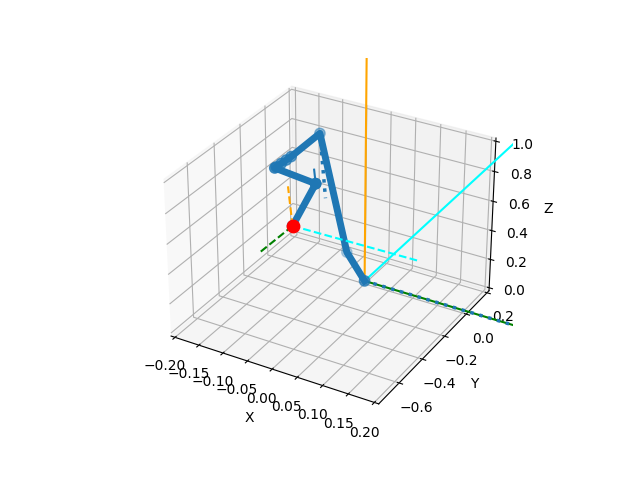

Button(description='Execute move', style=ButtonStyle())

Output()

In [33]:
move_to_grasp_goal(get_current_grasp_pose(), plot_prompt=True)

## Hello World Demo

In this demo, Stretch will write "Hello World" on a whiteboard using a dry erase marker. We'll do three things to make this demo work:

 1. Position the robot aligned to the whiteboard & get the current configuration
 2. Calculate the world points to write 'hello world'
 3. Use `move_to_pose_goal` to achieve the world points

In [34]:
# TODO